In [1]:
# LSTM + Attention 的结构

In [2]:
# 准备数据
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
import numpy as np
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt

In [3]:
np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

In [4]:
# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)
dataset = dataset.fillna(0)

In [5]:
# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
TRAIN_VALIDATION_RATIO = 0.9
TRAIN_BATCH_SIZE = 40                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1
SEQ_LENGTH = 25
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))

# TEST_BATCH_COUNT  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
TEST_BATCH_SIZE  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
if TEST_BATCH_SIZE == 0:                                                                   # 如果 rolling_data 刚好被整除，那就专门留一整块给test，全部算一个batch
    TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
TEST_BATCH_COUNT = 1
TRAIN_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) * TRAIN_VALIDATION_RATIO)
VALID_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) - TRAIN_BATCH_COUNT)

print("TRAIN_BATCH_COUNT : {}".format(TRAIN_BATCH_COUNT))
print("VALID_BATCH_COUNT : {}".format(VALID_BATCH_COUNT))
print("TEST_BATCH_COUNT  : {}".format(TEST_BATCH_COUNT))

# train = rolling_data[:-test_seq_count].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# test  = rolling_data[-test_seq_count:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = rolling_data[:TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE].reshape(TRAIN_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
valid = rolling_data[TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE:-TEST_BATCH_COUNT*TEST_BATCH_SIZE].reshape(VALID_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)     # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-TEST_BATCH_COUNT*TEST_BATCH_SIZE:].reshape(TEST_BATCH_COUNT, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_COUNT = train.shape[0]
TRAIN_BATCH_SIZE = train.shape[1]
VALID_BATCH_COUNT = valid.shape[0]
VALID_BATCH_SIZE = valid.shape[1]
TEST_BATCH_COUNT = test.shape[0]
TEST_BATCH_SIZE = test.shape[1]

train = torch.tensor(train)
valid = torch.tensor(valid)
test  = torch.tensor(test)


train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
valid_x, valid_y = valid[:,:,:,Y_SEQ_LEN:], valid[:,:,-1:,0:Y_SEQ_LEN]           # [valid_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
valid_y = valid_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]


train_x = train_x.to(device)
train_y = train_y.to(device)
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("valid_x: {}".format(valid_x.shape))
print("valid_y: {}".format(valid_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("valid_batch_count: {}".format(valid.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (786, 25, 139)
seq count: 786
seq length: 25
TRAIN_BATCH_COUNT : 17
VALID_BATCH_COUNT : 2
TEST_BATCH_COUNT  : 1
train_x: torch.Size([17, 40, 25, 138])
train_y: torch.Size([17, 40, 1, 1])
valid_x: torch.Size([2, 40, 25, 138])
valid_y: torch.Size([2, 40, 1, 1])
test_x:  torch.Size([1, 26, 25, 138])
test_y:  torch.Size([1, 26, 1, 1])
train_batch_count: 17
valid_batch_count: 2
test_batch_count:  1


In [6]:
# 定义 LSTM 模型

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim_size, num_layers, output_size, attention_size=5, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_dim_size
        self.sequence_length = SEQ_LENGTH
        self.attention_size = attention_size
        
        self.dropout = nn.Dropout(dropout)
        
        self.lstm1 = nn.LSTM(input_size=input_size,        hidden_size=hidden_dim_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(input_size=hidden_dim_size, hidden_size=hidden_dim_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        self.linear_1 = nn.Linear(hidden_dim_size, hidden_dim_size)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(hidden_dim_size, output_size)
        
        self.num_layers = num_layers

        # self.h10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_dim_size/2)*num_layers).double().to(device)
        # self.c10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_dim_size/2)*num_layers).double().to(device)
        # self.h20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_dim_size*num_layers).double().to(device)
        # self.c20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_dim_size*num_layers).double().to(device)
        
        self.attention_size = attention_size
        # w_omega means W_w
        # u_omega means U_w
        self.w_omega = Variable(torch.zeros(self.hidden_size, self.attention_size).double().to(device))
        self.u_omega = Variable(torch.zeros(self.attention_size).double().to(device))
        
        self.init_weights2()

    def init_weights1(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def init_weights2(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
                
    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
    
    def attention_net(self, lstm_output, query, mask=None):
        # print(lstm_output.size())                                                   # [batch_size, seq_len, hidden_dim_size]
        # print(query.size())                                                         # [batch_size, seq_len, hidden_dim_size]
        # k = lstm_output.dropout()
        # q = lstm_output.transpose(1,2)
        # v = lstm_output
        d_k = query.size(-1)                                                        # d_k为query的维度
        scores = torch.matmul(query, lstm_output.transpose(1, 2)) / math.sqrt(d_k)  #打分机制  [batch_size, seq_len, hid_dim] * [batch_size, hid_dim, seq_len] ==> scores:[batch_size, seq_len, seq_len], 每个值就是两个输入x元素的相似性

        p_attn = F.softmax(scores, dim = -1)                                        #对最后一个维度归一化得分  [batch_size, seq_len, seq_len] 保证相似性在一行上归一了。

        context = torch.matmul(p_attn, lstm_output)                                 #对权重化的x求和，[batch_size, seq_len, seq_len] * [batch, seq_len, hidden_dim] ==> [batch_size, seq_len, hidden_dim_size]
        # print(context.shape)
        
        context = torch.matmul(p_attn, lstm_output)                                 #对权重化的x求和，[batch_size, seq_len, seq_len] * [batch, seq_len, hidden_dim] ==> [batch_size, hidden_dim_size]
        # print(context.shape)
       
        attention = self.linear_1(context)
        
        return attention      
        
    
    def forward(self, x, hidden, cell):

        # layer 1
        x = self.dropout(x)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch        
        # LSTM layer
        # lstm_out, (h_n, c_n) = self.lstm(x, (self.h0.detach(), self.c0.detach()))
        
        lstm1_out, (h1_n, c1_n) = self.lstm1(x, (hidden, cell))
        
        lstm1_out = self.dropout(lstm1_out)
        
        lstm_out, (h2_n, c2_n) = self.lstm2(lstm1_out, (h1_n, c1_n))
        
        query = self.dropout(lstm_out)

        attn_output = self.attention_net(lstm_out, query)       #和LSTM的不同就在于这一句
        
        predictions = self.linear_2(attn_output)
        
        return predictions, h2_n, c2_n


In [7]:
# 训练 LSTM 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异

HIDDEN_SIZE = 1024
NUM_LAYERS = 2

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

#MAPE——平均绝对百分比误差  mean_absolute_percent_error
def MAPE(y_pred ,y_true):
    absolute_percent_error = (torch.abs(y_pred-y_true)+1e-7)/(torch.abs(y_true)+1e-7)
    return torch.mean(absolute_percent_error)

model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).double().to(device)
LR = 1e-5
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)

9 of 200 epoch   train_loss: 1.067618   valid_loss: 0.948775
19 of 200 epoch   train_loss: 0.673191   valid_loss: 0.841390
29 of 200 epoch   train_loss: 0.507721   valid_loss: 0.395431
39 of 200 epoch   train_loss: 0.341118   valid_loss: 0.575752
49 of 200 epoch   train_loss: 0.336976   valid_loss: 0.395453
59 of 200 epoch   train_loss: 0.252708   valid_loss: 0.497222
69 of 200 epoch   train_loss: 0.335704   valid_loss: 0.470510
79 of 200 epoch   train_loss: 0.184835   valid_loss: 0.444160
89 of 200 epoch   train_loss: 0.307092   valid_loss: 0.388182
99 of 200 epoch   train_loss: 0.197592   valid_loss: 0.399359
109 of 200 epoch   train_loss: 0.272300   valid_loss: 0.218176
119 of 200 epoch   train_loss: 0.270881   valid_loss: 0.369412
129 of 200 epoch   train_loss: 0.217425   valid_loss: 0.447250
139 of 200 epoch   train_loss: 0.155267   valid_loss: 0.358249
149 of 200 epoch   train_loss: 0.183398   valid_loss: 0.520250
159 of 200 epoch   train_loss: 0.267956   valid_loss: 0.287380
169

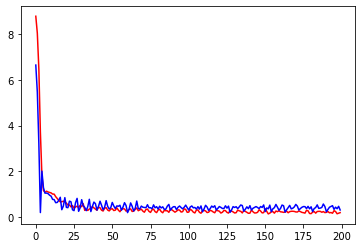

In [8]:
# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epoches = 200
train_epoch_loss = 0
train_epoch_loss_list = []
valid_smallest_loss = 1
valid_smallest_epoch = 0
valid_epoch_loss = 0
valid_epoch_loss_list = []

train_batch_count = train_x.shape[0]
valid_batch_count = valid_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)


for epoch in range(epoches):
    batch_loss = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0,train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
    # print(batch_loss)
    train_epoch_loss = np.mean(batch_loss)

    batch_loss = []
    valid_epoch_loss = 0
    valid_pred_value_list = []
    valid_real_value_list = []
    for step in range(valid_batch_count):
        valid_pred, hn, cn = model(valid_x[step], h0, c0)
        loss = loss_func(valid_pred[:,-1], valid_y[step][:,-1,-1])
        valid_pred_value_list.extend(list(valid_pred[:,-1].cpu().detach().flatten().numpy()))
        valid_real_value_list.extend(list(valid_y[step,:,-1,-1].cpu().detach().flatten().numpy()))
        batch_loss.append(loss.cpu().data.numpy())
    # print(batch_loss)
    valid_epoch_loss = np.mean(batch_loss)
    
    if ((epoch+1) %10) == 0:
        print("{} of {} epoch   train_loss: {:.6f}   valid_loss: {:.6f}".format(epoch, epoches, train_epoch_loss, valid_epoch_loss))

    valid_epoch_loss_list.append(valid_epoch_loss)
    train_epoch_loss_list.append(train_epoch_loss)

plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show()    

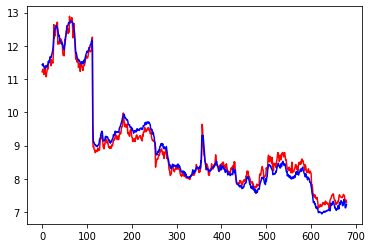

In [9]:
# 这是 train 的预测图形
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()
# print(train_real_value_list)

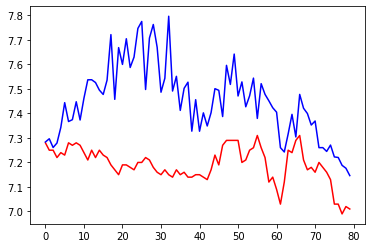

In [10]:
# 这是 vali的预测图形
plt.plot(valid_real_value_list, 'r-')
plt.plot(valid_pred_value_list, 'b-')
plt.show()

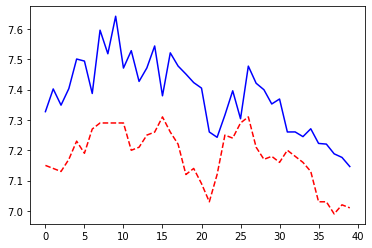

[7.15 7.14 7.13 7.17 7.23 7.19 7.27 7.29 7.29 7.29 7.29 7.2  7.21 7.25
 7.26 7.31 7.26 7.22 7.12 7.14 7.09 7.03 7.12 7.25 7.24 7.29 7.31 7.21
 7.17 7.18 7.16 7.2  7.18 7.16 7.13 7.03 7.03 6.99 7.02 7.01]
[7.32736015 7.40226073 7.34879184 7.40335395 7.50096352 7.49420302
 7.38726958 7.59606668 7.51830465 7.6420751  7.47111908 7.52850931
 7.42710211 7.47168596 7.54400631 7.37964514 7.52134603 7.47778932
 7.45141088 7.42321434 7.40503973 7.26022679 7.24273372 7.31606779
 7.39615404 7.30398588 7.47753305 7.42106319 7.39964961 7.35265339
 7.36905799 7.26029647 7.26047082 7.24496325 7.27088071 7.22251853
 7.22031623 7.18819777 7.17640333 7.14632233]
tensor([7.1500, 7.1400, 7.1300, 7.1700, 7.2300, 7.1900, 7.2700, 7.2900, 7.2900,
        7.2900, 7.2900, 7.2000, 7.2100, 7.2500, 7.2600, 7.3100, 7.2600, 7.2200,
        7.1200, 7.1400, 7.0900, 7.0300, 7.1200, 7.2500, 7.2400, 7.2900, 7.3100,
        7.2100, 7.1700, 7.1800, 7.1600, 7.2000, 7.1800, 7.1600, 7.1300, 7.0300,
        7.0300, 6.9900, 7.02

In [11]:
# 这是 valid 最后一段的数据。误差累积到这里已经很大了。
plt.plot(valid_y[-1,:,-1,-1].cpu().detach().flatten().numpy(), 'r--')
plt.plot(valid_pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
print(valid_y[-1,:,-1,-1].cpu().detach().flatten().numpy())
print(valid_pred[:,-1].cpu().detach().flatten().numpy())
print(valid_y[-1,:,-1,-1])

Test Loss : 1.520841
Prediction: 7.41
Actual:     0.00


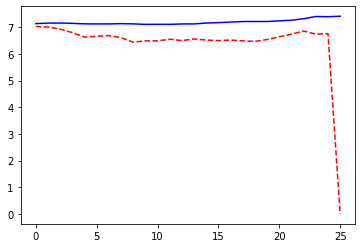

tensor([7.0300, 7.0100, 6.9300, 6.8000, 6.6300, 6.6600, 6.6900, 6.6100, 6.4400,
        6.4900, 6.4900, 6.5500, 6.5000, 6.5600, 6.5200, 6.5000, 6.5200, 6.4900,
        6.4700, 6.5400, 6.6400, 6.7400, 6.8600, 6.7400, 6.7600, 0.0000],
       device='cuda:0', dtype=torch.float64)
tensor([[7.1370],
        [7.1534],
        [7.1584],
        [7.1465],
        [7.1276],
        [7.1252],
        [7.1253],
        [7.1362],
        [7.1269],
        [7.1078],
        [7.1118],
        [7.1093],
        [7.1233],
        [7.1262],
        [7.1577],
        [7.1748],
        [7.1938],
        [7.2149],
        [7.2160],
        [7.2156],
        [7.2393],
        [7.2640],
        [7.3195],
        [7.4025],
        [7.3962],
        [7.4130]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)


In [12]:
# 用模型预测数据
# 考虑到时序因素，这里的时候误差很大。
model.eval()
test_loss = 0

h0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)

for step in range(test_x.shape[0]):
    pred, hn, cn = model(test_x[step], h0, c0)
    
    loss = loss_func(pred[:,-1], test_y[step][:,-1,-1])               # Compare the all sequences' last element in one batch
    
    if test_x.shape[0] > 1:
        actual_line.append(test_y[step][-1,-1].item())
        pred_line.append(pred[-1,-1].item())
    elif test_x.shape[0] == 1:
        actual_line = test_y[step].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
        pred_line   = pred[:,-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
        
print("Test Loss : {:.6f}".format(loss.data))
print("Prediction: {:.2f}".format(float(pred[-1,-1].data)))
print("Actual:     {:.2f}".format(float(test_y[step][-1,-1].data)))


plt.plot(test_y[step,:,-1,-1].cpu().detach().flatten().numpy(), 'r--')
plt.plot(pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
print(test_y[step,:,-1,-1])
print(pred[:,-1])

In [13]:
# 把rolling_data再分割为 train / test 就再预测
# 既然 预测值 和时序相关性很高，可以考虑太早的零星数据对于test影响不大，可以删掉
print(rolling_data.shape)
print(TRAIN_BATCH_SIZE)
print(((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE)
rolling_data = rolling_data[-((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE-1:,]
print(rolling_data.shape)

train = rolling_data[:-1].reshape(-1, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-1:].reshape(1, 1, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

train = torch.tensor(train).to(device)
test  = torch.tensor(test).to(device)

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(test_y)

(786, 25, 139)
40
760
(761, 25, 139)
torch.Size([19, 40, 25, 138]) torch.Size([19, 40, 1, 1])
torch.Size([1, 1, 25, 138]) torch.Size([1, 1, 1, 1])
tensor([[[[0.]]]], device='cuda:0', dtype=torch.float64)


9 of 200 epoch   train_loss: 1.142743
19 of 200 epoch   train_loss: 0.645286
29 of 200 epoch   train_loss: 0.511200
39 of 200 epoch   train_loss: 0.530973
49 of 200 epoch   train_loss: 0.376049
59 of 200 epoch   train_loss: 0.480459
69 of 200 epoch   train_loss: 0.331145
79 of 200 epoch   train_loss: 0.417566
89 of 200 epoch   train_loss: 0.281414
99 of 200 epoch   train_loss: 0.358051
109 of 200 epoch   train_loss: 0.212916
119 of 200 epoch   train_loss: 0.355231
129 of 200 epoch   train_loss: 0.231251
139 of 200 epoch   train_loss: 0.334918
149 of 200 epoch   train_loss: 0.196258
159 of 200 epoch   train_loss: 0.320235
169 of 200 epoch   train_loss: 0.191034
179 of 200 epoch   train_loss: 0.314181
189 of 200 epoch   train_loss: 0.165850
199 of 200 epoch   train_loss: 0.290682


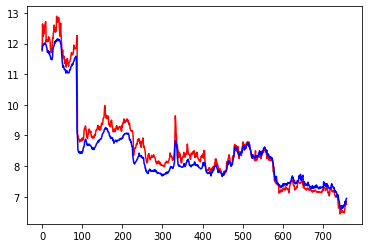

In [14]:
# 再重新生成模型再 train 模型
model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).double().to(device)
LR = 1e-5
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)
model.train()

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)


for epoch in range(epoches):
    batch_loss = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0,train_batch_count))
    # random.shuffle(train_batch_list)
    for step in range(0, train_x.shape[0]):
        train_pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
    if ((epoch+1) %10) == 0:
        print("{} of {} epoch   train_loss: {:.6f}".format(epoch, epoches, np.mean(batch_loss)))
    train_epoch_loss = np.mean(batch_loss)
    
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()    

In [15]:
print(train_pred.shape)
print(train_y.shape)

print(train_y[-1,-1])
print(train_pred[-1,-1])

torch.Size([40, 25, 1])
torch.Size([19, 40, 1, 1])
tensor([[6.7600]], device='cuda:0', dtype=torch.float64)
tensor([6.9468], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)


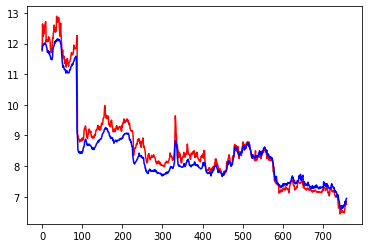

In [16]:
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()

In [17]:
# print(train_x.shape)
# print(test_x.shape)
print(train_real_value_list[-1])
print(train_pred_value_list[-1])

6.76
6.946778036792242


In [18]:
model.eval()

h0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)

pred, hn, cn = model(test_x[-1], h0, c0)

print(test_y.shape)
print(pred.shape)
print(test_y)
print(pred[:,-1,:])

torch.Size([1, 1, 1, 1])
torch.Size([1, 25, 1])
tensor([[[[0.]]]], device='cuda:0', dtype=torch.float64)
tensor([[6.8721]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward0>)
